# 6 - Working with Rasters

Any numpy array can be turned into a `gplately.Raster`:

```python
raster = gplately.Raster(
    plate_reconstruction=model,
    data=array,
    extent="global",  # equivalent to (-180, 180, -90, 90)
    origin="lower",  # or set extent to (-180, 180, -90, 90)
)
```

In this notebook, we will:

- Download rasters from EarthByte's webDAV server
- Plot rasters
- Resize and respace rasters
- Reconstruct rasters
- Linearly interpolate point data on rasters
- Query raster
- Clip raster by extent

Import all needed packages, and create [`PlateReconstruction`](https://gplates.github.io/gplately/reconstruction.html#gplately.reconstruction.PlateReconstruction) and [`Plot`](https://gplates.github.io/gplately/plot.html) objects for the [Muller et al. (2019)](https://doi.org/10.1029/2018TC005462) plate tectonic model.

In [1]:
import os

import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import numpy as np
from plate_model_manager import PlateModelManager, PresentDayRasterManager

Using GPlately's [`download`](https://gplates.github.io/gplately/download.html) module, we can easily download a variety of plate tectonic models!

In [2]:
%%capture cap
pm_manager = PlateModelManager()
muller2019_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")

rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
static_polygons = muller2019_model.get_static_polygons()

coastlines = muller2019_model.get_layer('Coastlines')
continents = muller2019_model.get_layer('ContinentalPolygons')
COBs =  muller2019_model.get_layer('COBs')

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs)

## [`PlateModelManager`](https://pypi.org/project/plate-model-manager/) for rasters

Let's use [`PlateModelManager`](https://pypi.org/project/plate-model-manager/) to download Muller et al. 2019 netCDF age grids. 

There is a unique age grid for each millionth year - let's access the 0 Ma age grid by passing `time` to [`get_age_grid`](https://gplates.github.io/gplately/download.html#gplately.download.DataServer.get_age_grid). It is returned as a gplately `Raster` object which we call `muller_2019_age_grid`.

In [3]:
time = 0  # Ma
muller_2019_age_grid = gplately.Raster(
    data=muller2019_model.get_raster("AgeGrids", time),
    plate_reconstruction=model,
    extent=[-180, 180, -90, 90],
    )

## Plotting rasters
The `muller_2019_age_grid` is a [`Raster`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster) object - this object allows us to work with age grids and other rasters. Let's visualise the data with [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

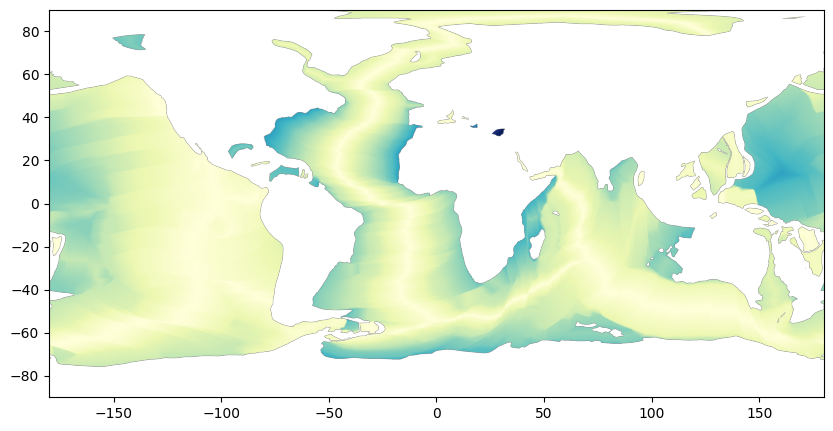

In [4]:
fig = plt.figure(figsize=(10, 6))
muller_2019_age_grid.imshow(cmap="YlGnBu")
plt.show()

Let's plot this netCDF grid along with coastlines, mid-ocean ridges and subduction zones (with teeth) resolved from the Muller et al. 2019 plate model.

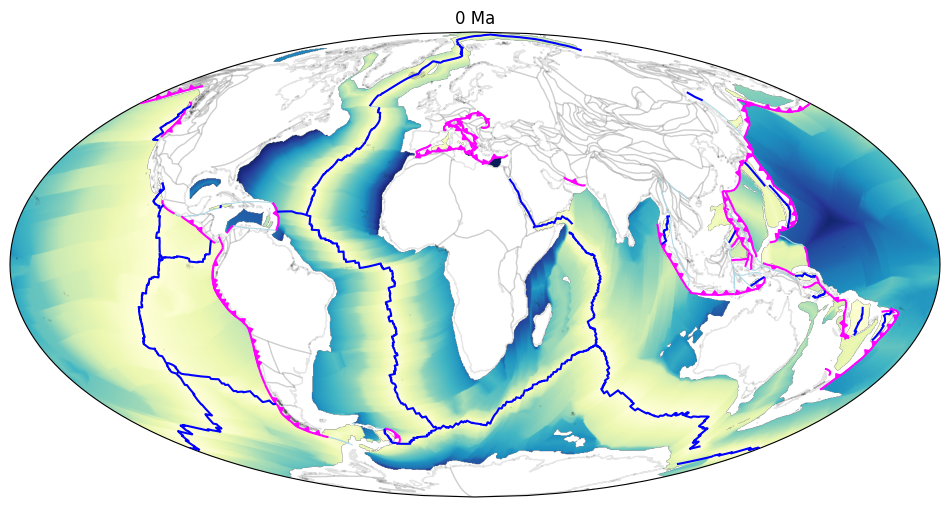

In [5]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=20))

gplot.time = time

muller_2019_age_grid.imshow(ax1, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='1', alpha=0.1)
gplot.plot_trenches(ax1, color='magenta', zorder=5)
gplot.plot_ridges(ax1, color='b', zorder=5)
gplot.plot_transforms(ax1, color='lightblue', linewidth=0.75)
gplot.plot_subduction_teeth(ax1, color='magenta')
ax1.set_title("{} Ma".format(time))
plt.show()

## Resizing and resampling rasters

Let's resize and resample the the present-day Muller et al. 2019 agegrid.
We can do this using [`resize`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.resize).

- `resize` - provide the number of points in each direction to resize the raster (e.g. 100 cols by 200 rows)
- `resample` - provide the grid spacing in each direction (e.g. 0.1 degrees by 0.2 degrees)

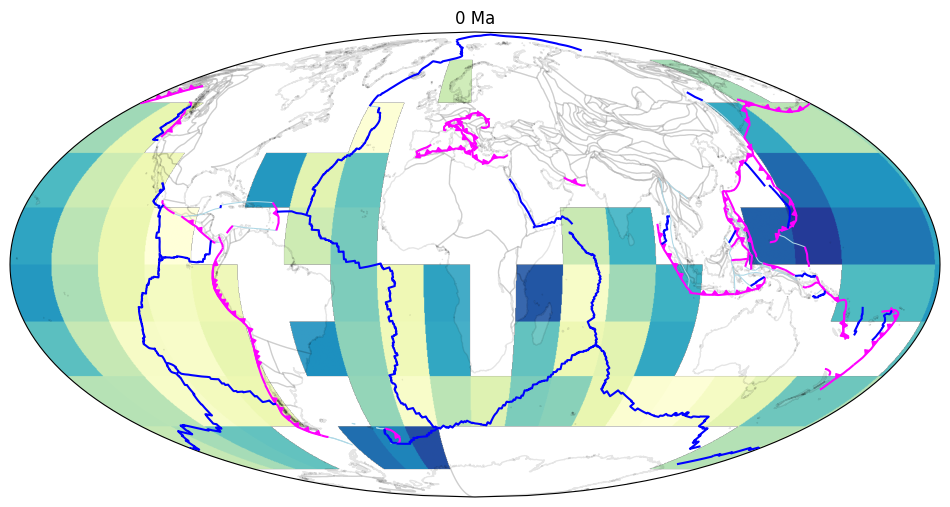

In [6]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

muller_2019_age_grid = gplately.Raster(
    data=muller2019_model.get_raster("AgeGrids", time),
    plate_reconstruction=model,
    extent=[-180, 180, -90, 90],
    )

# Set grid size in x and y directions
muller_2019_age_grid.resize(20, 10, inplace=True)

# Plot resampled and resized age grid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 20))
muller_2019_age_grid.imshow(ax1, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='1', alpha=0.1)
gplot.plot_trenches(ax1, color='magenta', zorder=5)
gplot.plot_ridges(ax1, color='b', zorder=5)
gplot.plot_transforms(ax1, color='lightblue', linewidth=0.75)
gplot.plot_subduction_teeth(ax1, color='magenta')
ax1.set_title("{} Ma".format(time))
plt.show()

## Downloading general rasters

Let's visualise an ETOPO1 relief raster. GPlately also makes it easy to import, using [`get_raster`](https://gplates.github.io/gplately/download.html#gplately.download.DataServer.get_raster)

Alternatively, you can import a local netcdf file using by passing the filename to [`gplately.grids.Raster`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster) or [`gplately.grids.read_netcdf_grid`](https://gplates.github.io/gplately/grids.html#gplately.grids.read_netcdf_grid)

In [7]:
# This returns ETOPO1 as a `Raster` object.
from matplotlib import image
raster_manager = PresentDayRasterManager()
etopo = gplately.Raster(data=image.imread(raster_manager.get_raster("ETOPO1_tif")))
etopo.lats = etopo.lats[::-1]

print(np.shape(etopo))

(2700, 5400, 3)


`etopo` is a large (5400 x 2700 pixels) RGB image, with a total of 14,580,000 grid points. We can visualise it using a number of methods, including [`Raster.imshow`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.imshow).

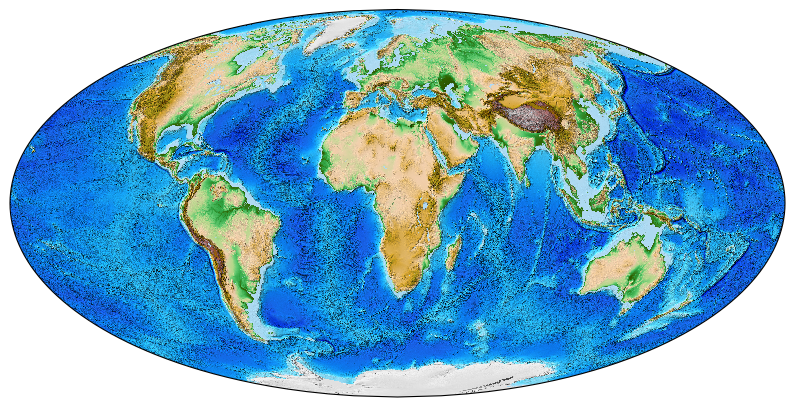

In [8]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=20))
etopo.imshow(ax=ax1, interpolation="none")
plt.show()

We can also resize this RGB raster using the [`Raster.resize`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.resize) and [`Raster.resample`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.resample) methods. Here we resample it to a 0.5 by 0.5 degree resolution, then plot it using [`Raster.imshow`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.imshow).

(361, 721, 3)


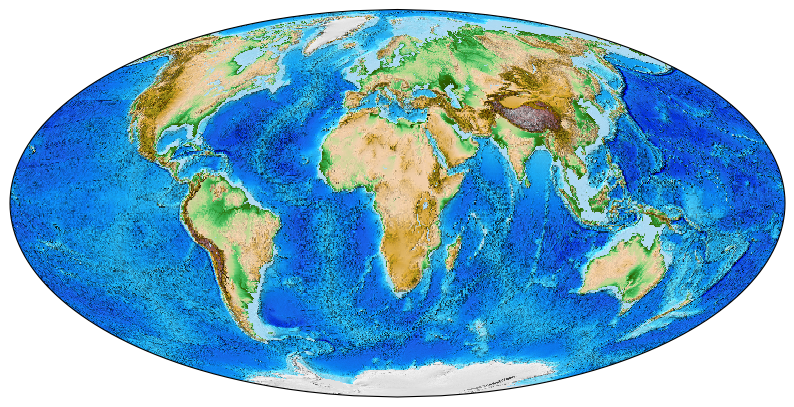

In [9]:
etopo_downscaled = etopo.resample(0.5,0.5)
print(etopo_downscaled.shape)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=20))
etopo_downscaled.imshow(ax1, interpolation="none")

## Reconstructing rasters

The ETOPO1 raster can be reconstructed back in time by assigning a `plate_reconstruction` to the object. We use the plate reconstruction we defined earlier (`model`). Note that a `Raster` object will also accept a `plate_reconstruction` at initialisation.

After this, we use [`reconstruct`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.reconstruct) to reconstruct the raster to a given time.

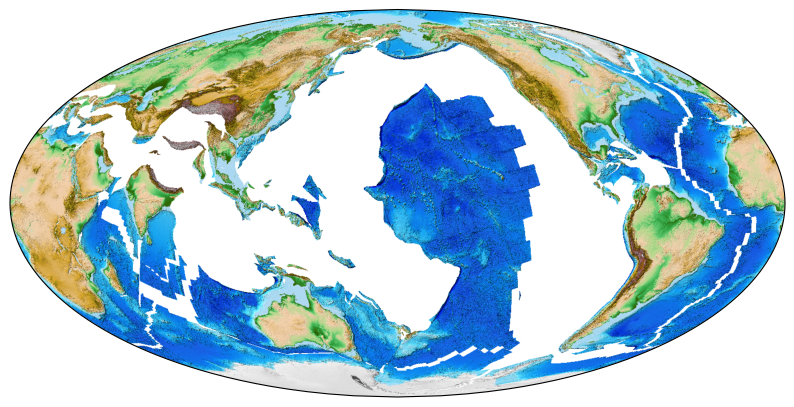

In [10]:
# assign a plate reconstruction in order to reconstruct the raster
etopo.plate_reconstruction = model

white_rgb = (255, 255, 255)  # RGB code for white, to fill gaps in output
etopo_reconstructed = etopo.reconstruct(50, threads=4, fill_value=white_rgb)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=180))
etopo_reconstructed.imshow(ax1)

`Raster` can be reconstructed in-place (`inplace=True`), and `fill_value` can be set to any valid matplotlib colour when reconstructing RGB images.

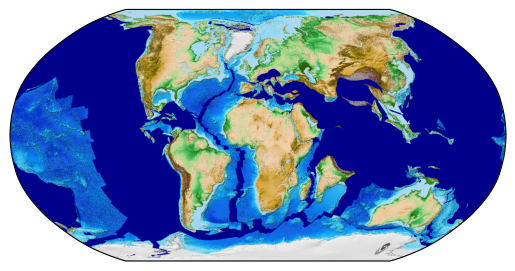

In [11]:
# create a duplicate of the obj
etopo_dup = etopo.copy()

etopo_dup.reconstruct(time=75, threads=4, fill_value="darkblue", inplace=True)
etopo_dup.imshow(projection=ccrs.Robinson())

By default, [`Raster.reconstruct`]([`reconstruct`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.reconstruct) uses `self.plate_reconstruction.static_polygons` to assign plate IDs to grid points. To override this behaviour, pass any collection of `pygplates.Feature` (e.g. `list`, `pygplates.FeatureCollection`, etc) to the `partitioning_features` argument.

Text(0.5, 1.0, 'Reconstructed to 140 Ma')

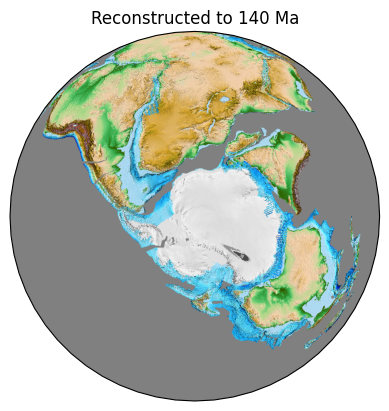

In [12]:
etopo_reconstructed = etopo.reconstruct(140, partitioning_features=continents, threads=4, fill_value="grey")
etopo_reconstructed.imshow(projection=ccrs.Orthographic(0, -80))
plt.gca().set_title("Reconstructed to 140 Ma")

## Reverse reconstructions

Rasters can be also be reverse reconstructed forward in time!

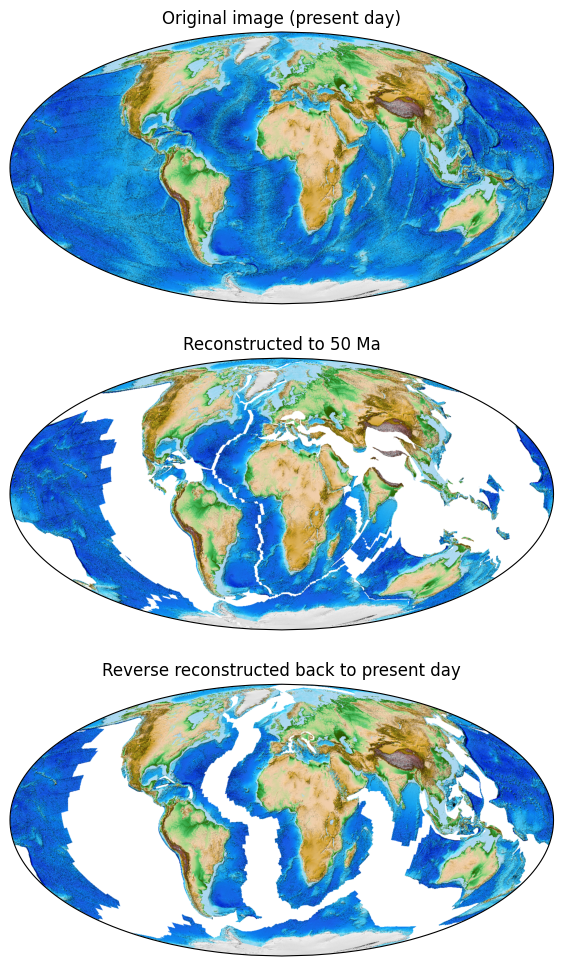

In [13]:
reconstructed = etopo.reconstruct(50, fill_value="white", threads=4)

reverse_reconstructed = reconstructed.reconstruct(0, fill_value="white", threads=4)

# plot
fig, axs = plt.subplots(3, 1, figsize=(8, 12), subplot_kw={"projection": ccrs.Mollweide(central_longitude=0)})
etopo.imshow(ax=axs[0])
reconstructed.imshow(ax=axs[1])
reverse_reconstructed.imshow(ax=axs[2])

axs[0].set_title("Original image (present day)")
axs[1].set_title("Reconstructed to 50 Ma")
axs[2].set_title("Reverse reconstructed back to present day")
plt.show()

## Reconstructing netCDF rasters

Similar to above, we can also reconstruct numeric netcdf grids! GPlately also includes ETOPO1 as a netcdf for download.

C:\Users\jcann\Development\Usyd\source_code\repositories\GPlates\gplately\gplately\grids.py:820: RuntimeWarning: Invalid values encountered in lat; clipping to [-90, 90]


(361, 721)


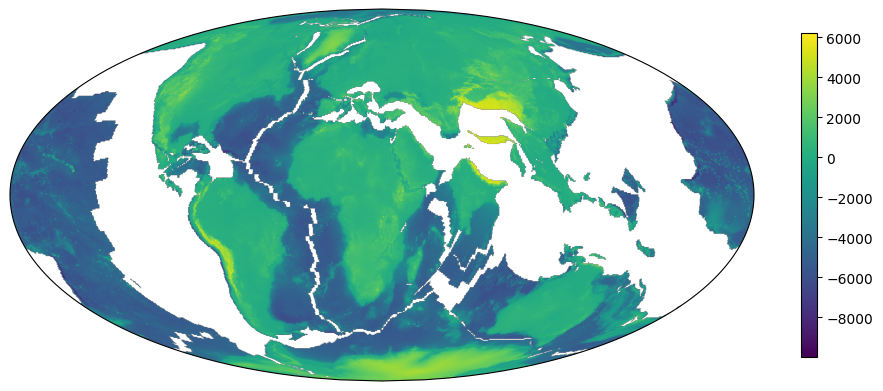

In [14]:
# ETOPO1 downloaded as a Raster object
raster_manager = PresentDayRasterManager()
etopo_nc = gplately.Raster(data=raster_manager.get_raster("ETOPO1_grd"))
etopo_nc._data = etopo_nc._data.astype(float)

# resample to a more manageable size
etopo_nc.resample(0.5, 0.5, inplace=True)
print(etopo_nc.shape)

# Assign plate reconstruction
etopo_nc.plate_reconstruction = model

# Reconstruct raster to 50 Ma
etopo_nc_reconstructed = etopo_nc.reconstruct(50, threads=4)

# plot
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=20))
im1 = etopo_nc_reconstructed.imshow(ax1)
fig.colorbar(im1, ax=ax1, pad=0.05, shrink=0.7)
plt.show()

The reconstructed netcdf can also be saved.

In [15]:
# Save the reconstructed ETOPO grid to netCDF 
# (note: this ETOPO netCDF grid is high-res, ~190+ MB)
save_filename = os.path.join(
    "NotebookFiles",
    "reconstructed_etopo.nc",
)

etopo_nc_reconstructed.save_to_netcdf4(save_filename)

## Linear interpolation 

As an example of linear interpolation, let's find which subduction zones form continental arcs. For this we use continental netcdf4 files and sample these at points projected 250 km from the trench (in the direction of the subducting plate) to determine if they are inside a continent.

In [16]:
# Define the continental grid
continental_grid_filename = os.path.join(
    "NotebookFiles",
    "continental_grid_0.nc",
)
continental_raster = gplately.Raster(
    continental_grid_filename,
    model,
    extent="global",
)

# tessellate trenches and extract subduction polarity angle, and the lat-lon coordinates
trench_data = model.tessellate_subduction_zones(time)
trench_normal_azimuthal_angle = trench_data[:, 7]
trench_pt_lon = trench_data[:, 0]
trench_pt_lat = trench_data[:, 1]
    
# calculate 250 km arc distance
arc_distance = 250 / (gplately.tools.geocentric_radius(trench_pt_lat) / 1e3)
    
# Lat and lon coordinates of all trench points after being projected out 250 km in the direction of subduction.
dlon = arc_distance * np.sin(np.radians(trench_normal_azimuthal_angle))
dlat = arc_distance * np.cos(np.radians(trench_normal_azimuthal_angle))
ilon = trench_pt_lon + np.degrees(dlon)
ilat = trench_pt_lat + np.degrees(dlat)

Let's use GPlately to linearly interpolate these projected trench points onto the continental grids using [`Raster.interpolate`](https://gplates.github.io/gplately/grids.html#gplately.grids.Raster.interpolate)

In [17]:
# Use GPlately to interpolate these new points on the defined grid
sampled_points = continental_raster.interpolate(ilon, ilat, method='linear')

# sampled_point[0] is a list of points in the grid (ascribed the integer 1). Collect their indices. 
in_raster_indices = sampled_points > 0

# Get the lat-lon coordinates of the in_raster points
lat_in = ilat[in_raster_indices]
lon_in = ilon[in_raster_indices]

Plot the in-raster points along with the raster, trenches, and coastlines.

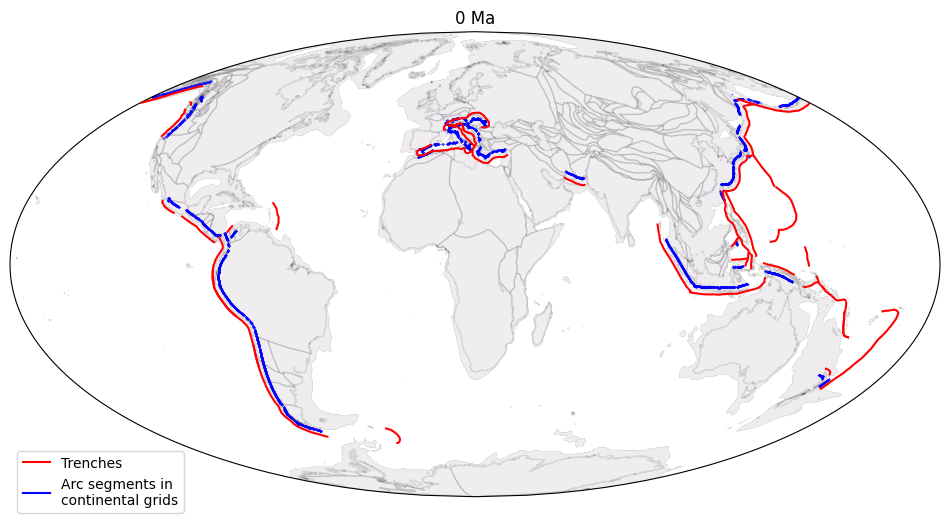

In [18]:
fig = plt.figure(figsize=(12, 8), dpi=100)
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=20))
gplot.time = time
gplot.plot_grid_from_netCDF(ax1, continental_grid_filename, cmap="twilight", alpha=0.5, vmin=0, vmax=200)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='1', alpha=0.1)
gplot.plot_trenches(ax1, color='r', zorder=5)

# Plot the trench points in-continent
ax1.plot(
    lon_in, lat_in,
    linestyle="none",
    marker="o",
    markersize=0.25,
    markerfacecolor="blue",
    markeredgecolor="blue",
    transform=ccrs.PlateCarree(),
)
plt.title("%i Ma" %time)

# Custom legend
from matplotlib.lines import Line2D

handles = [
    Line2D([0], [0], color="red"),
    Line2D([0], [0], color="blue"),
]
labels = [
    "Trenches",
    "Arc segments in \ncontinental grids",
]

plt.legend(handles, labels, loc="lower left",bbox_to_anchor=(0., -0.05))
plt.show()

### Query raster

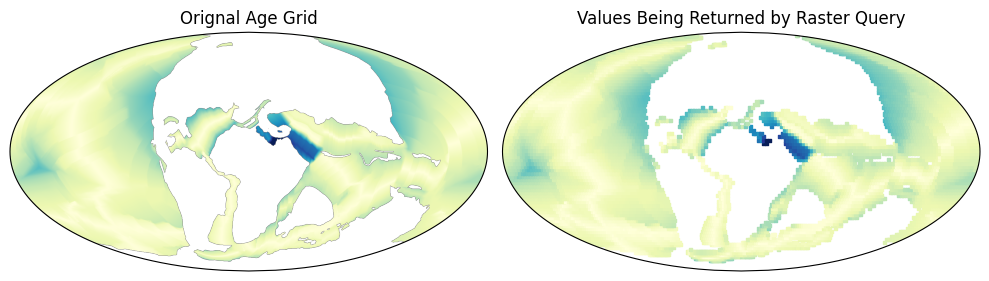

In [19]:
age_grid_raster = gplately.Raster(
    data=muller2019_model.get_raster("AgeGrids", 100),
    plate_reconstruction=model,
    extent=[-180, 180, -90, 90],
    )

# plot the original age grid raster
fig = plt.figure(figsize=(10,10), dpi=100)
ax_1 = fig.add_subplot(121, projection=ccrs.Mollweide(central_longitude = 0))
age_grid_raster.imshow(ax=ax_1, cmap="YlGnBu",vmax=200, vmin=0)
ax_1.set_title("Orignal Age Grid")

# plot the data being retrieved by raster query
ax_2 = fig.add_subplot(122, projection=ccrs.Mollweide(central_longitude = 0))
xx, yy = np.meshgrid(np.linspace(-180, 180, 180), np.linspace(-90, 90, 90))
values = age_grid_raster.query(
        lons=xx.flatten(), lats=yy.flatten(),region_of_interest=10)
ax_2.scatter(
        xx.flatten(),
        yy.flatten(),
        c=values,
        marker="s",
        s=5,
        transform=ccrs.PlateCarree(),
        cmap="YlGnBu",
        vmax=200,
        vmin=0,
    )
ax_2.set_title("Values Being Returned by Raster Query")
fig.tight_layout()
plt.show()

### Clip raster by extent

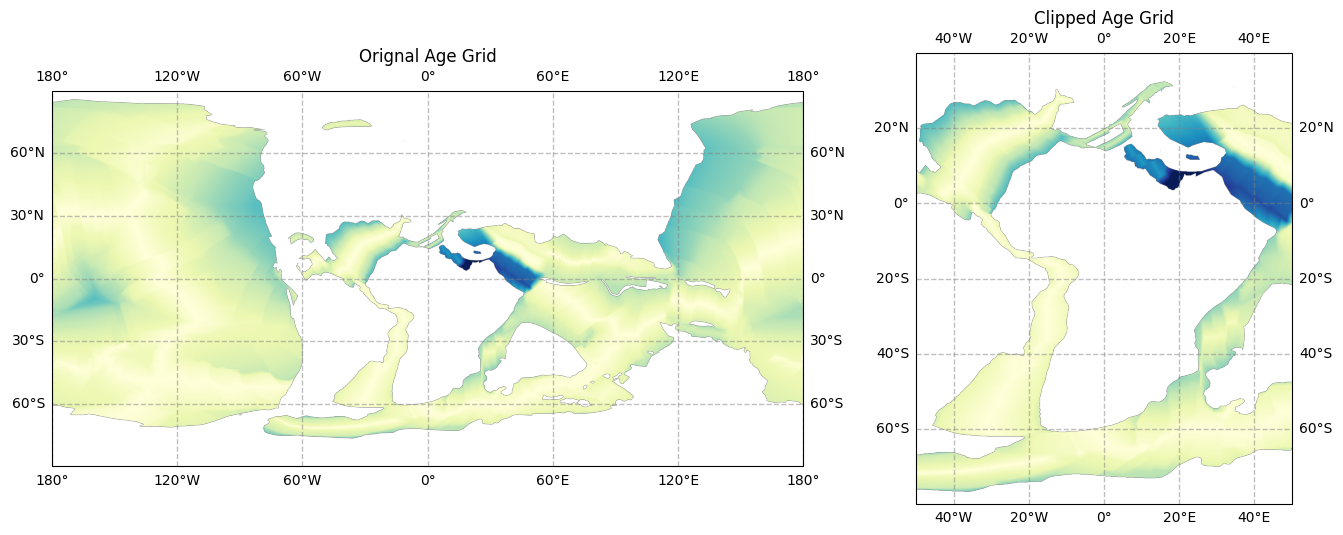

In [20]:
fig, axs = plt.subplots(1,2,figsize=(16,8), 
                        gridspec_kw={'width_ratios': [2, 1]},
                        subplot_kw={'projection': ccrs.PlateCarree()})
#fig.tight_layout()
ax_1=axs[0]
ax_2=axs[1]

# plot the original age grid raster
age_grid_raster.imshow(ax=ax_1, cmap="YlGnBu",vmax=200, vmin=0)
ax_1.set_title("Orignal Age Grid")
ax_1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

clipped_raster = age_grid_raster.clip_by_extent([-50, 50, -80, 40])

# plot the clipped raster
clipped_raster.plot(
    ax=ax_2,
    transform=ccrs.PlateCarree(),
    cmap="YlGnBu",
    vmax=200,
    vmin=0,
)
ax_2.set_title("Clipped Age Grid")
ax_2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.show()